All features are present.
Model for Adjusted net enrollment rate, primary Disparity:
  Mean Squared Error: 41.927177823769924
  R-squared: -4.140440115862542



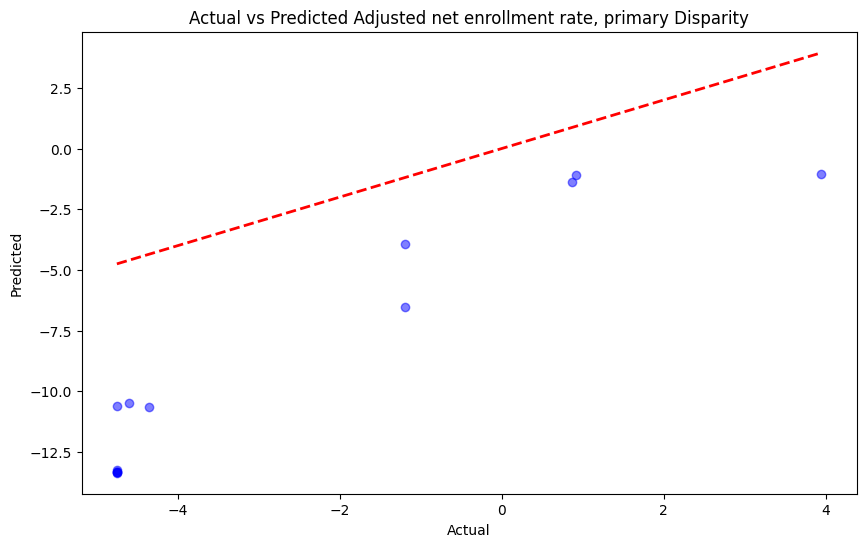

Model for Literacy rate, adult Disparity:
  Mean Squared Error: 244.76223007127894
  R-squared: -214.90273119609483



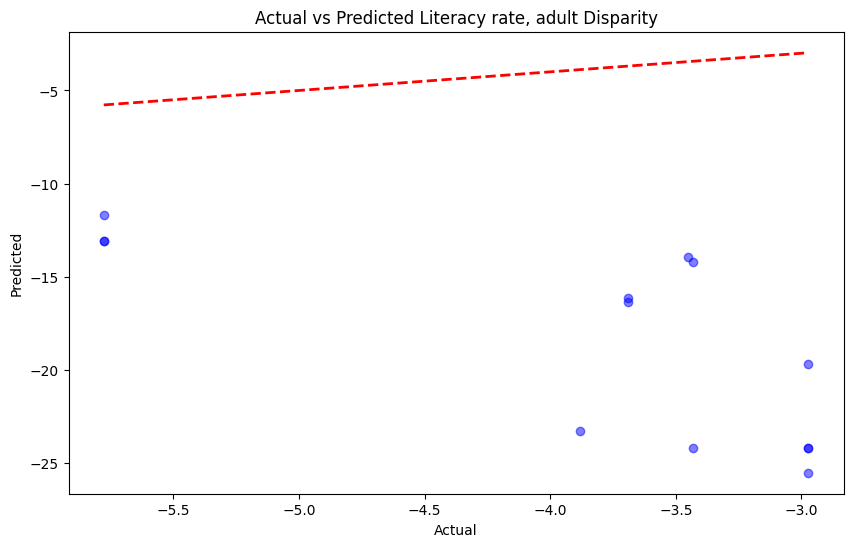

Model for Literacy rate, youth Disparity:
  Mean Squared Error: 34.264293371341516
  R-squared: -1239.8825798364405



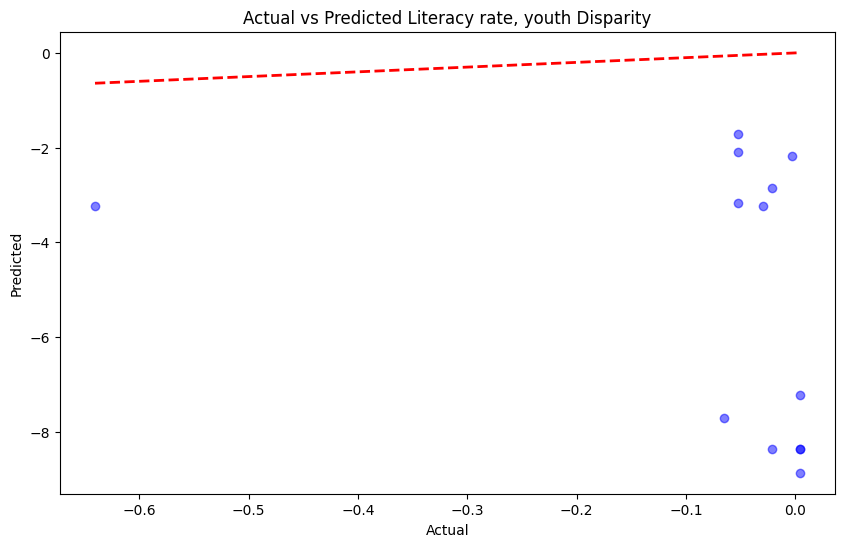

Model for Primary completion rate Disparity:
  Mean Squared Error: 15.218162493558895
  R-squared: -0.728218771048919



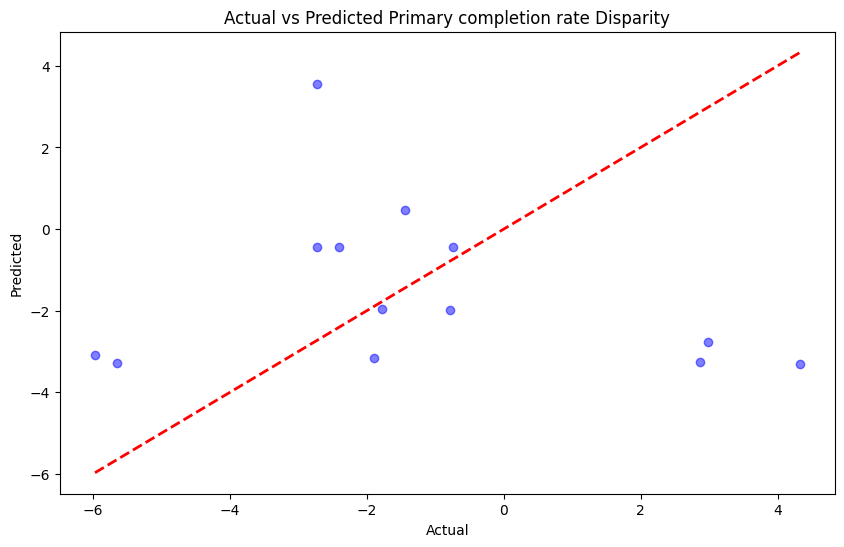

Model for Repeaters, primary Disparity:
  Mean Squared Error: 688.8154978903294
  R-squared: -1.825223747104285



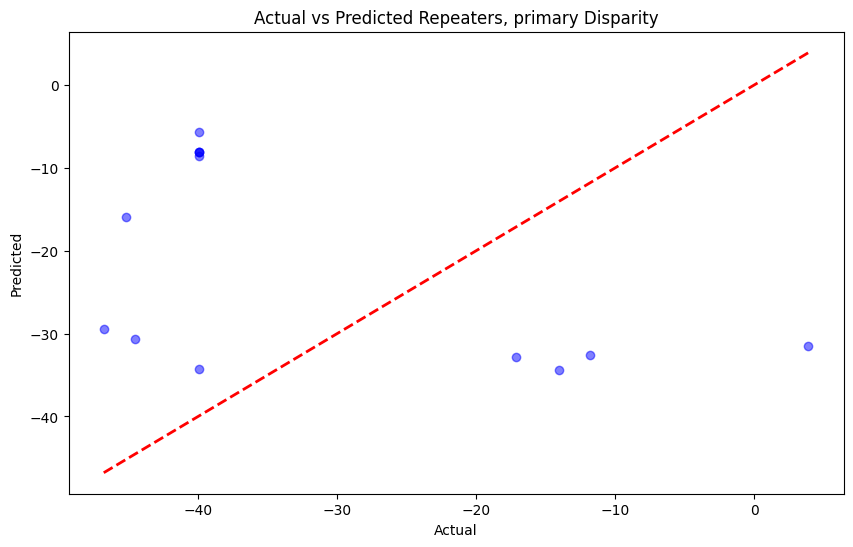

Model for School enrollment, preprimary Disparity:
  Mean Squared Error: 56.49763411282394
  R-squared: -0.28427347305423467



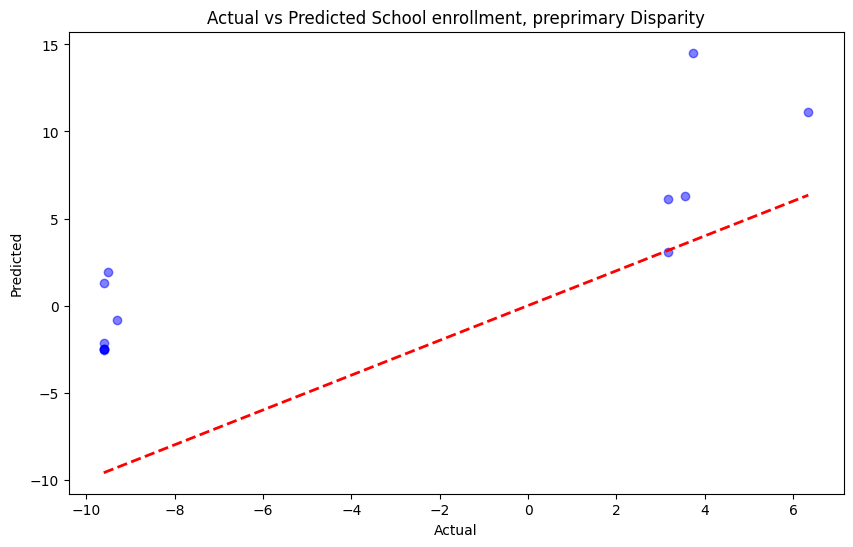

Model for School enrollment, primary (gross) Disparity:
  Mean Squared Error: 62.446769988576094
  R-squared: -14.979530408222972



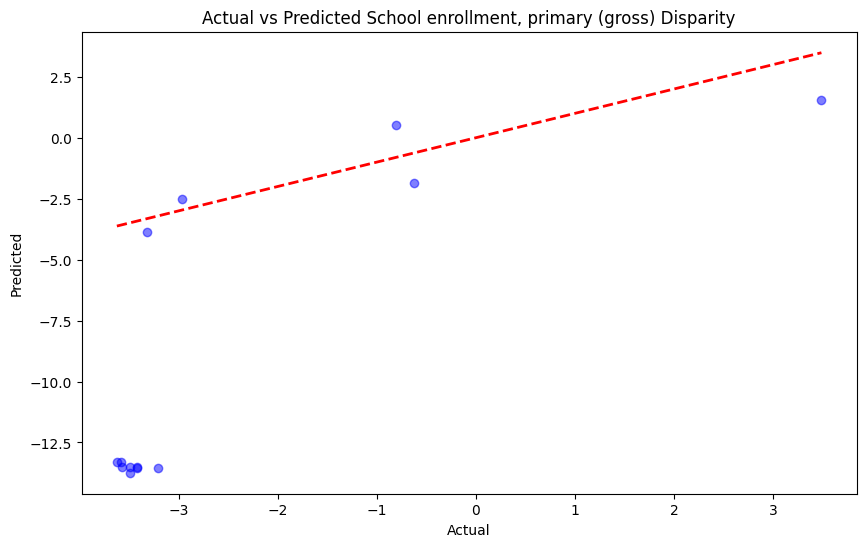

Model for School enrollment, primary (net) Disparity:
  Mean Squared Error: 38.787807969942044
  R-squared: -3.260043555420782



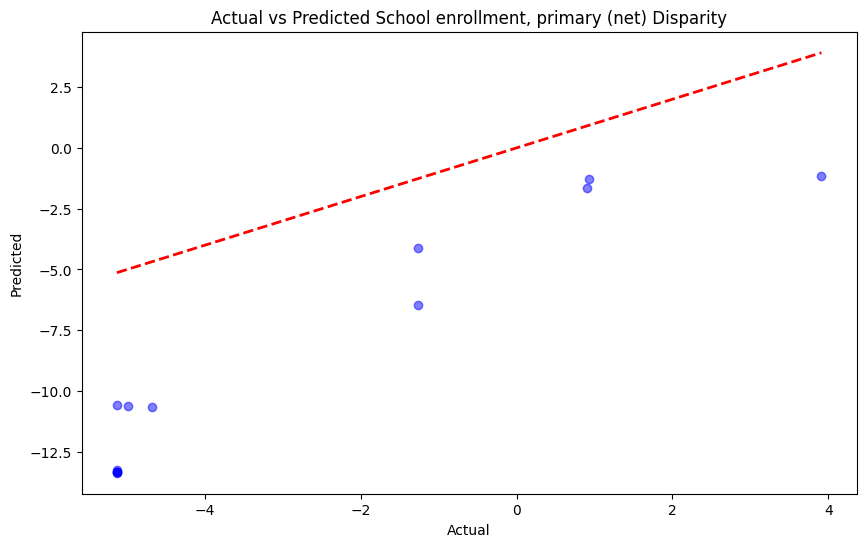

Model for School enrollment, secondary (gross) Disparity:
  Mean Squared Error: 1362.8553449849678
  R-squared: -604.327641410373



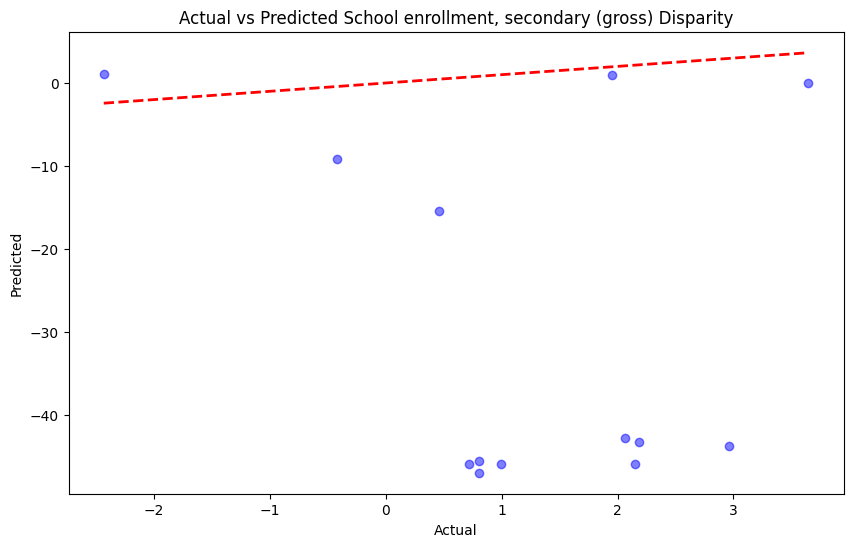

Model for School enrollment, secondary (net) Disparity:
  Mean Squared Error: 1055.3723664224651
  R-squared: -366.9927425104169



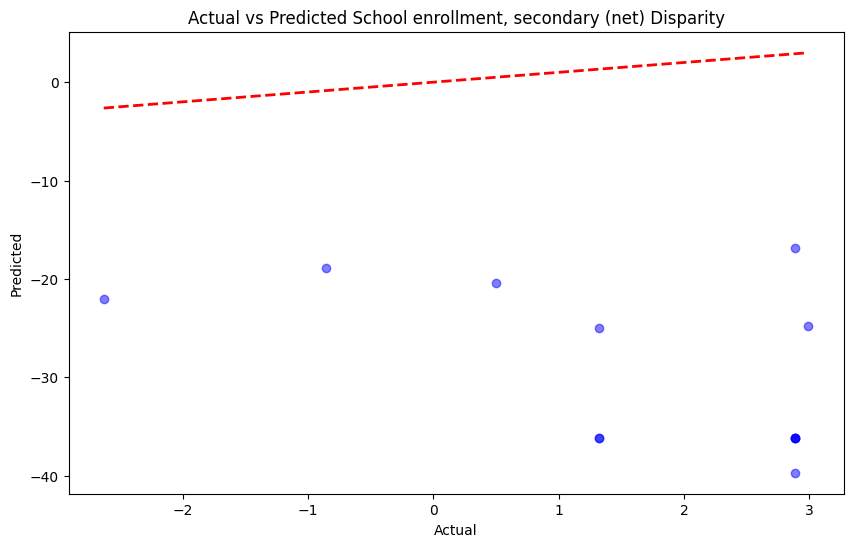

Model for School enrollment, tertiary Disparity:
  Mean Squared Error: 1453.300899144233
  R-squared: -24.15108266932431



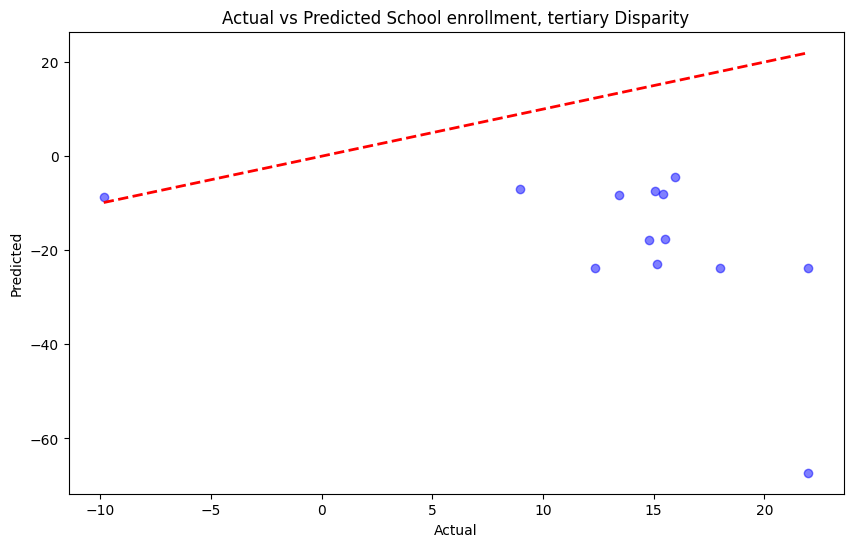

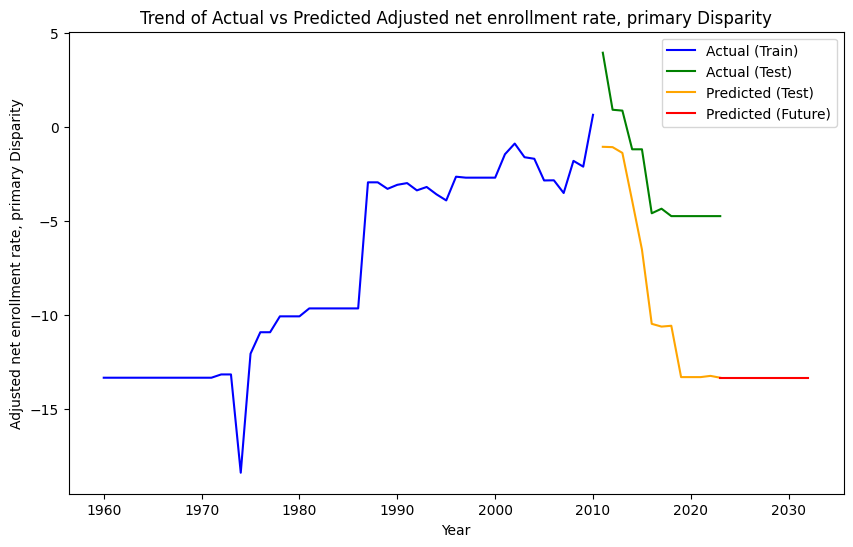

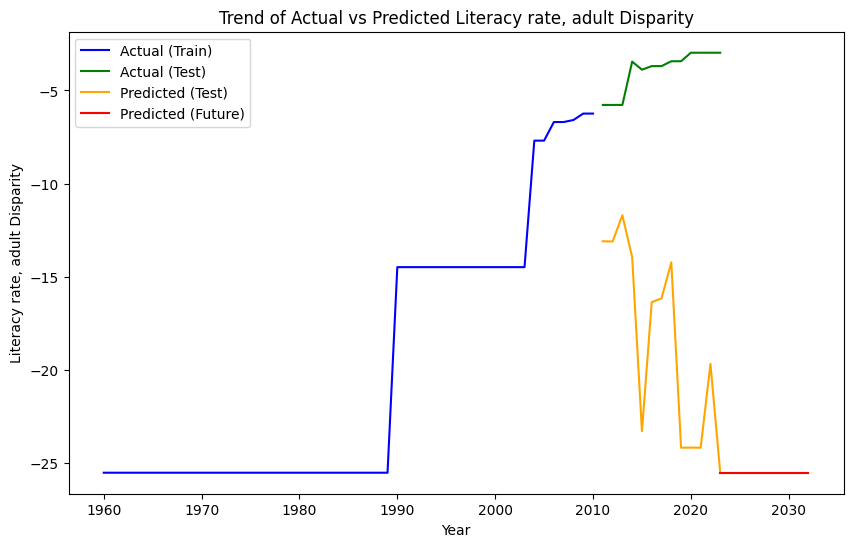

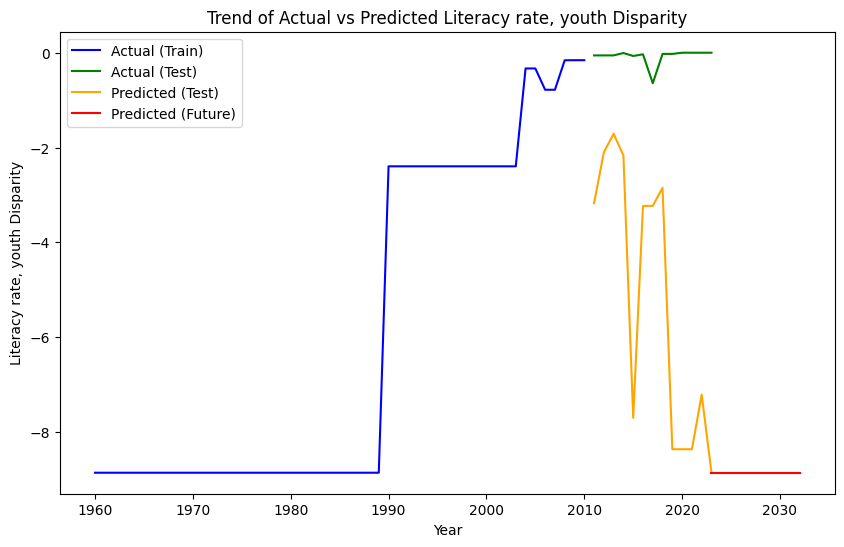

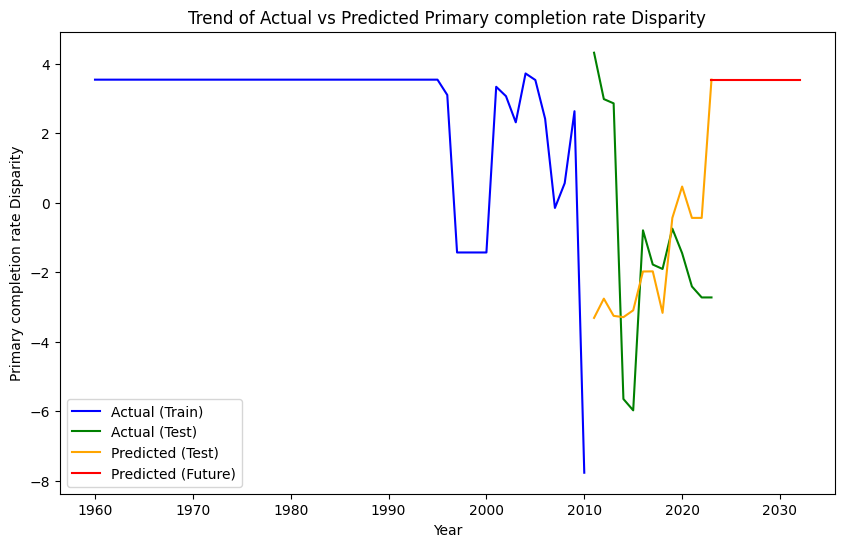

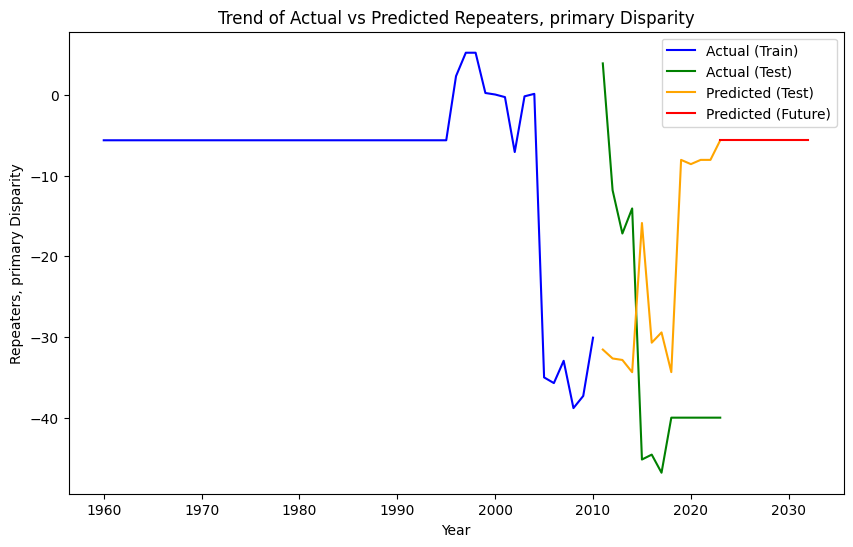

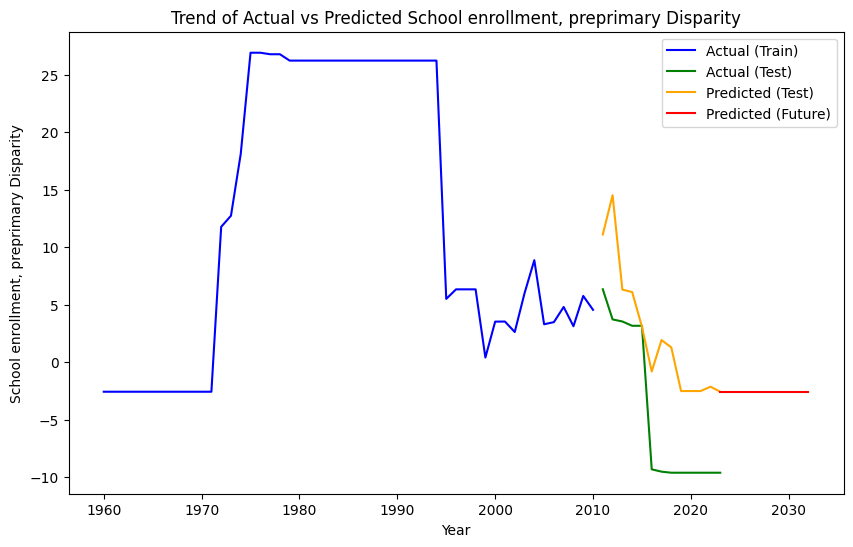

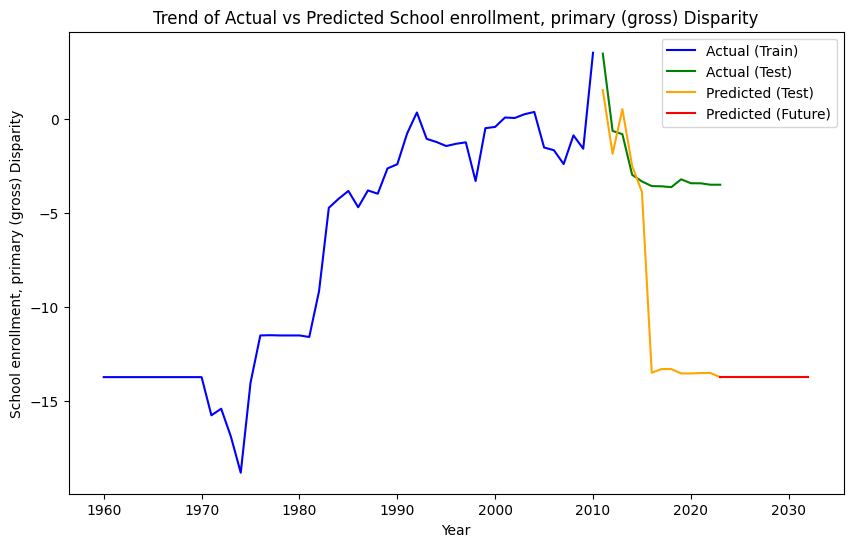

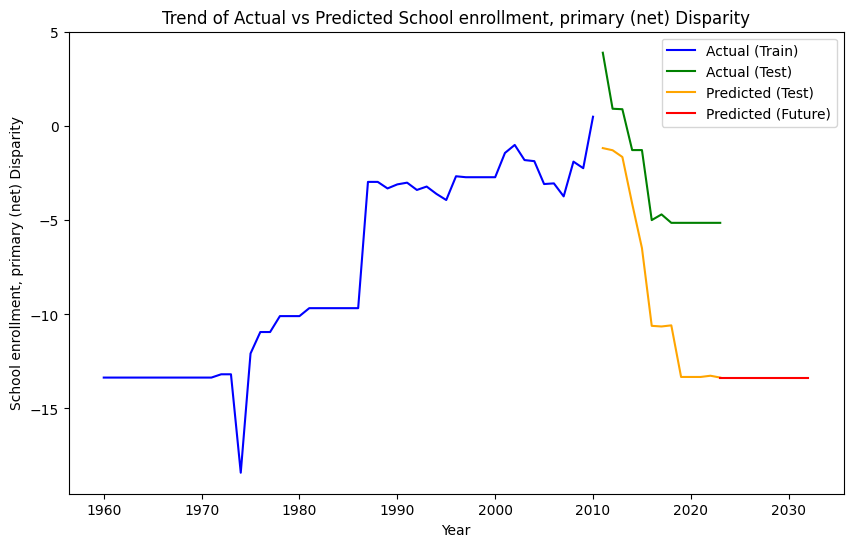

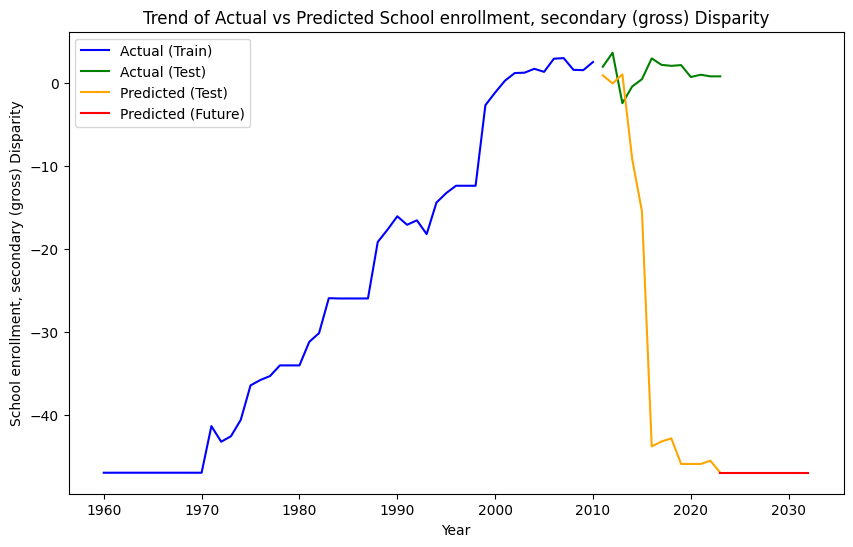

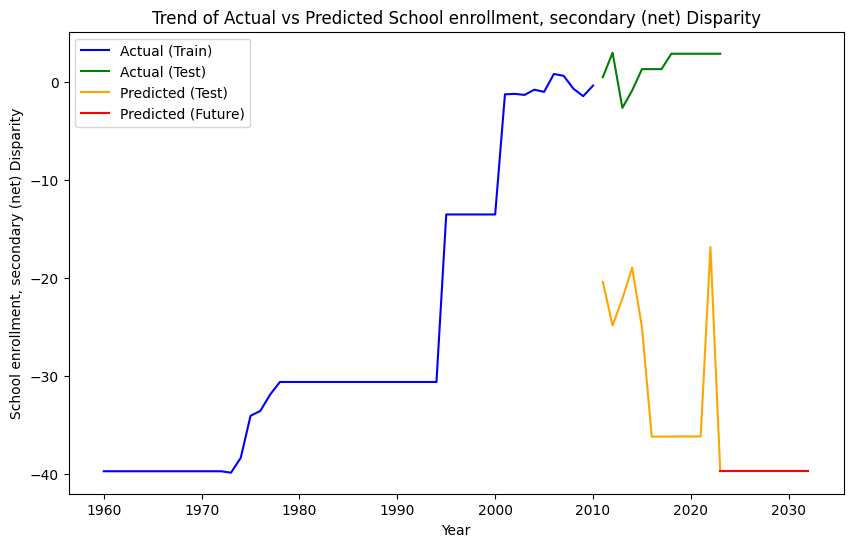

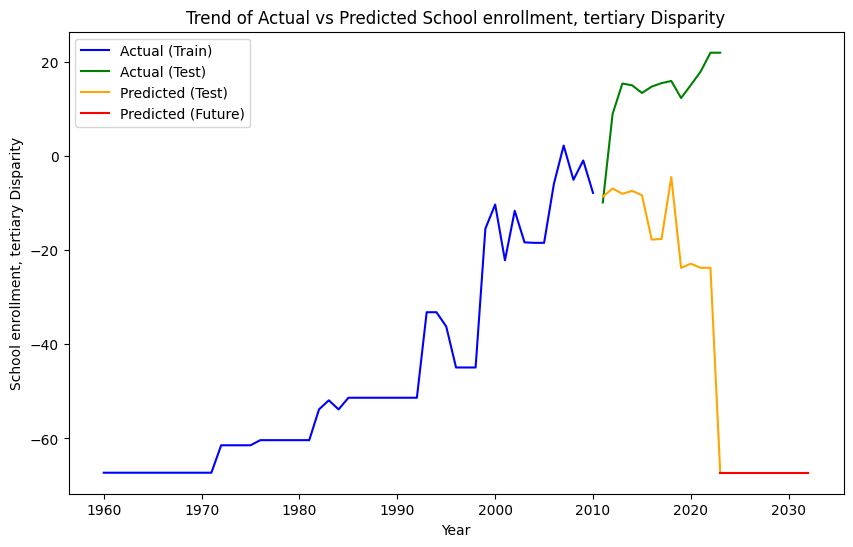

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the cleaned dataset with disparity index
file_path_disparity = 'Cleaned_Gender_IDN_with_Disparity.csv'
data_disparity = pd.read_csv(file_path_disparity)

# Load the original normalized dataset
file_path_original = 'Normalized_Gender_IDN.csv'
data_original = pd.read_csv(file_path_original)

# Clean column names in the original dataset
data_original.columns = data_original.columns.str.strip()

# Define features (X) based on columns in the original dataset
features = [
    'Adjusted net enrollment rate, primary, female (% of primary school age children)',
    'Adjusted net enrollment rate, primary, male (% of primary school age children)',
    'Literacy rate, adult female (% of females ages 15 and above)',
    'Literacy rate, adult male (% of males ages 15 and above)',
    'Literacy rate, youth female (% of females ages 15-24)',
    'Literacy rate, youth male (% of males ages 15-24)',
    'Primary completion rate, female (% of relevant age group)',
    'Primary completion rate, male (% of relevant age group)',
    'Repeaters, primary, female (% of female enrollment)',
    'Repeaters, primary, male (% of male enrollment)',
    'School enrollment, preprimary, female (% gross)',
    'School enrollment, preprimary, male (% gross)',
    'School enrollment, primary, female (% gross)',
    'School enrollment, primary, female (% net)',
    'School enrollment, primary, male (% gross)',
    'School enrollment, primary, male (% net)',
    'School enrollment, secondary, female (% gross)',
    'School enrollment, secondary, female (% net)',
    'School enrollment, secondary, male (% gross)',
    'School enrollment, secondary, male (% net)',
    'School enrollment, tertiary, female (% gross)',
    'School enrollment, tertiary, male (% gross)'
]

# Define targets (disparity indices) based on columns in the disparity dataset
targets = [
    'Adjusted net enrollment rate, primary Disparity',
    'Literacy rate, adult Disparity',
    'Literacy rate, youth Disparity',
    'Primary completion rate Disparity',
    'Repeaters, primary Disparity',
    'School enrollment, preprimary Disparity',
    'School enrollment, primary (gross) Disparity',
    'School enrollment, primary (net) Disparity',
    'School enrollment, secondary (gross) Disparity',
    'School enrollment, secondary (net) Disparity',
    'School enrollment, tertiary Disparity'
]

# Impute missing values in the original dataset
imputer = SimpleImputer(strategy='mean')
data_original_imputed = pd.DataFrame(imputer.fit_transform(data_original), columns=data_original.columns)

# Verify that all features are present in the dataset
missing_features = [feature for feature in features if feature not in data_original_imputed.columns]
if missing_features:
    print(f"Missing features in the dataset: {missing_features}")
else:
    print("All features are present.")

# Split the data into training (1960-2010) and testing sets (2011-2022)
train_data = data_original_imputed[data_original_imputed['Year'] <= 2010]
test_data = data_original_imputed[data_original_imputed['Year'] > 2010]

# Corresponding disparity indices
train_disparity = data_disparity[data_disparity['Year'] <= 2010]
test_disparity = data_disparity[data_disparity['Year'] > 2010]

# Create a Random Forest model for each target (disparity index)
models = {}
predictions = {}
for target in targets:
    # Prepare features and target
    X_train = train_data[features]
    y_train = train_disparity[target]
    X_test = test_data[features]
    y_test = test_disparity[target]

    # Train the Random Forest regression model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    models[target] = model

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    predictions[target] = y_pred

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Model for {target}:')
    print(f'  Mean Squared Error: {mse}')
    print(f'  R-squared: {r2}')
    print()

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {target}')
    plt.show()

# Predicting future disparities using rolling window approach

# Generate future years
future_years = np.arange(2023, 2033)

# Make predictions for future years
future_predictions = {}
for target in targets:
    model = models[target]
    current_year = test_data['Year'].max()
    X_future = test_data[features].iloc[-1].copy().to_frame().T
    future_pred = []
    
    for year in future_years:
        # Predict the disparity for the next year
        pred = model.predict(X_future)[0]
        future_pred.append(pred)
        
        # Update the features for the next prediction (use a simplistic approach here)
        for feature in features:
            X_future[feature] = X_future[feature].values[0]  # Use the last known value for simplicity
    
    future_predictions[target] = future_pred

# Visualize the trend of predicted vs actual disparity index over time
for target in targets:
    plt.figure(figsize=(10, 6))
    plt.plot(train_disparity['Year'], train_disparity[target], label='Actual (Train)', color='blue')
    plt.plot(test_disparity['Year'], test_disparity[target], label='Actual (Test)', color='green')
    plt.plot(test_disparity['Year'], predictions[target], label='Predicted (Test)', color='orange')
    plt.plot(future_years, future_predictions[target], label='Predicted (Future)', color='red')
    plt.xlabel('Year')
    plt.ylabel(target)
    plt.title(f'Trend of Actual vs Predicted {target}')
    plt.legend()
    plt.show()